<a href="https://colab.research.google.com/github/kenwkliu/ideas/blob/master/colab/StockClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pairs with stocks in the **same sector** share the same **macro fundamental factors** and prevent spurious correlation. However, it may be too **restrictive** and excludes some pairs opportunities

For example, "Photovoltaic Solar" and "Glass strands" (upstream/downstream in the industry) may be correlated but they're in different sectors

Use **clustering alogrithms** (such as k-mean ) to group similar stocks together based on their **return** and **volatility**. Select the pairs of  stocks from the same cluster.

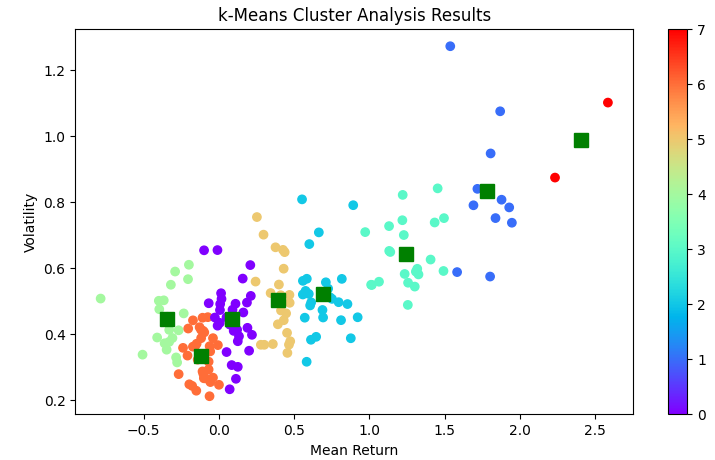

In [ ]:
#@title Choose the language to display the stock names and run this block to import libraries and helper functions
language = 'English' #@param ["English", "Chinese"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

import warnings
warnings.filterwarnings('ignore')


In [ ]:
#@title Load the highly correlated HK Pairs
if language == 'Chinese':
  pairsDf = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/hkCorrelatedPairsChi.csv')
else:
  pairsDf = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/hkCorrelatedPairs.csv')

pairsDf

In [ ]:
#@title Load the stocks histocial adjusted close price
if language == 'Chinese':
  researchData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/researchHKStocksAdjClosePxChi.csv', index_col=0)
else:
  researchData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/researchHKStocksAdjClosePx.csv', index_col=0)

researchData

In [ ]:
#@title Descriptive statistics: central tendency, dispersion and shape of a dataset
researchData.describe().T.round(4)

In [ ]:
#@title Calculate stock return and volatility

# Calculate the annualized return
TRADING_DAYS = 252
returns = researchData.pct_change().mean() * TRADING_DAYS
returns = pd.DataFrame(returns)
returns.columns = ['returns']

# Calculate the annualized volatility
returns['volatility'] = researchData.pct_change().std() * np.sqrt(TRADING_DAYS)
returns

In [ ]:
#@title Use K-mean to cluster the stocks (return, volatility) into different groups and use elbow method to find the optimal k (numbers of clusters)
from sklearn.cluster import KMeans
from sklearn import metrics

K = range(1,15)
distortions = []
returns.dropna(inplace = True)

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(returns)
    distortions.append(kmeans.inertia_)

#Plot the results
fig = plt.figure(figsize= (15, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [ ]:
#@title Pick the number of clusters (k)
num_clusters = 8 #@param {type:"integer"}

#Fit the model
k_means = KMeans(n_clusters=num_clusters).fit(returns)
prediction = k_means.predict(returns)

#Plot the results
centroids = k_means.cluster_centers_
#fig = plt.figure(figsize = (18,10))
fig = plt.figure(figsize = (9,5))

ax = fig.add_subplot(111)
scatter = ax.scatter(returns.iloc[:,0], returns.iloc[:,1], c=k_means.labels_, cmap="rainbow", label=returns.index)

ax.set_title('k-Means Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')

plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=10)
plt.show()

In [ ]:
#@title Plot the number of stocks in each cluster
clustered_series = pd.Series(index=returns.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=returns.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]

plt.figure(figsize=(12,8))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Clusters')

plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')

plt.show()

In [ ]:
#@title Show the stocks and the corresponding clusters
clusterDf = clustered_series.to_frame().reset_index()
clusterDf.rename(columns = {'index': 'stock', 0 : 'cluster'}, inplace=True)
clusterDf

In [ ]:
#@title Merge the cluster info back to the stock Pairs
cols = ['stockA', 'stockB', 'corr', 'cluster_A', 'cluster_B']
clusterPairsDf = pairsDf.merge(clusterDf, how='left', left_on='stockA', right_on='stock').merge(clusterDf, how='left', left_on='stockB', right_on='stock', suffixes=('_A', '_B'))[cols]
clusterPairsDf['sameCluster'] = (clusterPairsDf['cluster_A'] == clusterPairsDf['cluster_B'])

clusterPairsDf

## Time-series based clustering
https://tslearn.readthedocs.io/en/stable/user_guide/clustering.html

https://medium.datadriveninvestor.com/one-cool-way-to-spot-correlations-in-finance-dynamic-time-warping-763a6e7f0ee3

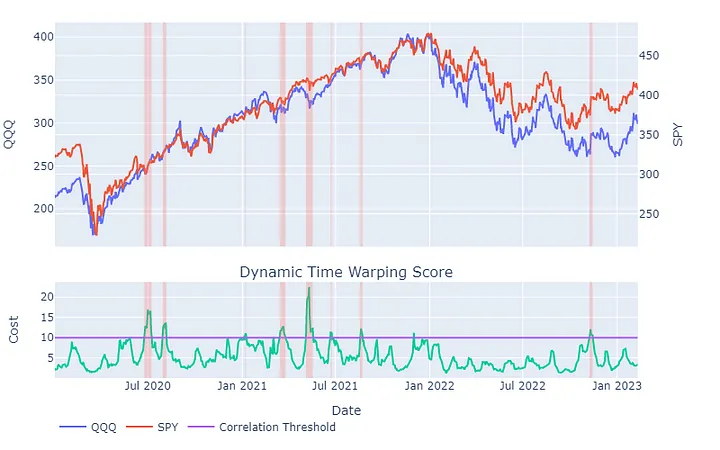

In [ ]:
#@title Import tslearn (time series) libary and normalize the stock price series
!pip install -q tslearn
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import Normalizer

researchData.dropna(inplace=True)

# Normalize the price series
normalizer = Normalizer()
researchDataPriceNormalized = normalizer.fit_transform(researchData.T.reset_index(drop=True))
researchDataPriceNormalized

In [ ]:
#@title Use DTW (Dynamic Time Warping) to form the stock clustering
tskm = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw")
tskm.fit(researchDataPriceNormalized)

tskm_labels = tskm.labels_
tskm_labels

In [ ]:
#@title Display the DTW clustering results

stock_names = researchData.columns
tskmDf = pd.DataFrame(tskm_labels, stock_names)
tskmDf.rename(columns = {0 : 'cluster'}, inplace=True)
tskmDf

In [ ]:
#@title Stocks clustering by fundamental data such as EPS (Earnings per Share), P/E (Price-to-Earning), Dividend Yield, Debt-to-Equity Ratio, Return on Equity (ROE)
import yfinance as yf

ticker = '0700.HK' # @param ["0700.HK", "2628.HK", "0941.HK", "0939.HK"] {allow-input: true}

# Get stock info from Yahoo Finance
stock = yf.Ticker(ticker)
stock.info

In [ ]:
stock.quarterly_financials

In [ ]:
stock.quarterly_balance_sheet

In [ ]:
stock.quarterly_cashflow

In [ ]:
stock.major_holders

In [ ]:
stock.sustainability